In [1]:
'''Loading libraries'''
import pandas as pd 
import numpy as np 
from scipy.stats import dirichlet, beta, nbinom, norm
from scipy.special import loggamma,gamma
import time
import matplotlib.pyplot as plt


'''
Notes: 
- investigate lasso use to solve -inf part
- invest nan part
- when i add more columns the aceptance rate goes to 0. 
- Fix the saving files part, memory problms 
- Track running time
- create a function to save files/images with a labeled name 
'''


'''Important parameters I need to constantly change'''
k = 100

sim = 500
start_time = time.time()


In [2]:
'''Loading dataset'''
#filename = "C:\\Users\\raoki\\Documents\\GitHub\\project_spring2019\\Data\\data_final.csv"
filename = "C:\\Users\\raque\\Google Drive\\SFU\\Project 2 - Spring 2019\\Data\\data_final.csv"
#filename = "C:\\Users\\raque\\Google Drive\\SFU\\Project 2 - Spring 2019\\Data\\data_final_sub.csv"
data = pd.read_csv(filename, sep=',')


In [3]:
'''Saving time in the first part'''

data = data.iloc[:, 0:1000]
data = data.sample(n=j).reset_index(drop=True)
data.shape


(1500, 1000)

In [4]:
'''Organizing columns names'''
lr = data.columns[[2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]
y = data.columns[3]
remove = data.columns[[0,1]]
#data_complete = data.copy()
for i in np.arange(19,data.shape[1]):
    data.iloc[:,i] = np.log(data.iloc[:,i]+1)

In [5]:
'''
Class to work with model parameters
I thought about using the default values as chain starting values, 
however, i encouter problems to change the size of arrays and matrices 
according with my currently k
'''
class parameters:
    def __init__(self, latent_v,latent_cj,latent_sk,latent_ev,latent_phi ,latent_tht, prediction):
        self.ln = latent_v #array with parameters that are only one number [0-c0,1-gamma0]
        self.la_cj = latent_cj #aaray J
        self.la_sk = latent_sk #array K
        self.la_ev = latent_ev #array V
        self.lm_phi = latent_phi #matrix (jk)
        self.lm_tht = latent_tht #matrix  (kv)      
        self.p = prediction #array [intercept, gender, 15 cancer types, k genes]


In [6]:
'''
Proposal distribution
NEED TO UPDATE

'''

#Proposal values for the parameters related to the factor model 
#Repete the parameters related to prediction and only propose
#new values for the factor analysys part
#output is the parameters class 
def proposal_f(current):
    new = parameters(np.random.normal(current.ln,0.05), 
                     np.random.normal(current.la_cj,2),
                     np.random.normal(current.la_sk,2),
                     np.random.normal(current.la_ev,0.05),
                     np.random.normal(current.lm_phi,0.000005), #remmeber that lm_phi sum up 1 in the line (genes)
                     np.random.normal(current.lm_tht,50), #remember the average value is 1600
                     current.p)
    #phi and tht can't be negative 
    new.lm_phi[new.lm_phi<0] = 0.0000001 #this number needs to be smaller 
    col_sums = new.lm_phi.sum(axis=0)
    new.lm_phi = new.lm_phi / col_sums[np.newaxis,:]
    new.lm_tht[new.lm_tht<0]=0
    return new

#Proposal values for the parameters related to logistic regression 
#Repete the parameters related to factor analysis part and propose
#new values for the logistc regression parameters 
#output is the parameters class 
def proposal_p(current):
    new = parameters(current.ln,current.la_cj ,current.la_sk, #current.la_pj, 
                     current.la_ev, current.lm_phi, current.lm_tht, 
                     np.random.normal(current.p,0.5))
    return new

In [17]:
'''Ratio functions'''
def ration_f(p_new,p_cur, data_F,k):
    '''Priori Ration'''
    #log(1680)=7.42
    #J is samples and V is genes
    j = data_F.shape[0]
    v = data_F.shape[1]
    #A: phi_jk~Dir(eta_j)
    #print(loggamma(np.exp(np.sum(np.log(p_cur.la_ev)))),
    #       loggamma(np.exp(np.sum(np.log(p_new.la_ev)))))
    A0 = k*(loggamma(np.exp(np.sum(np.log(p_cur.la_ev))))-
           loggamma(np.exp(np.sum(np.log(p_new.la_ev)))))
    A1 = k*(np.sum(np.log(gamma(p_new.la_ev)))-np.sum(np.log(gamma(p_cur.la_ev))))
    A2 = np.matmul((p_new.la_ev-1),np.log(p_new.lm_phi)).sum()-np.matmul((p_cur.la_ev-1),np.log(p_cur.lm_phi)).sum()
    #print('A', p_cur.la_ev[0:5],np.log(p_cur.la_ev)[0:5],np.sum(np.log(p_cur.la_ev)))
    #B: eta_j~Gamma(a0,b0)
    a0 = 1/(2*v)
    b0 = 1/(2*v)
    B = (a0-1)*(np.log(p_new.la_ev)-np.log(p_cur.la_ev)).sum()+(p_cur.la_ev-p_new.la_ev).sum()/b0
    
    #C: theta_kl~Gamma(sk,cj)
    C0 = j*(loggamma(p_cur.la_sk).sum()-loggamma(p_new.la_sk).sum())+(
    p_cur.la_sk.sum()*np.log(p_cur.la_cj).sum()-p_new.la_sk.sum()*np.log(p_new.la_cj).sum())
    C1 = np.matmul(p_new.la_sk-1,np.log(p_new.lm_tht).sum(axis=1))-np.matmul(
        p_cur.la_sk-1,np.log(p_cur.lm_tht).sum(axis=1))
    C2 = np.divide(p_cur.lm_tht.sum(axis=0),p_cur.la_cj).sum()-np.divide(p_new.lm_tht.sum(axis=0),p_new.la_cj).sum()
    
    #D: sk~Gamma(gamma0,c0), gamma0 = c0 = (v*averageExpression)^0.5
    average4 = np.sqrt(np.sqrt(v*7.42))
    gamma0 = average4
    c0 = average4
    D = (gamma0-1)*(np.log(p_new.la_sk)-np.log(p_cur.la_sk)).sum()+(p_cur.la_sk-p_new.la_sk).sum()/c0
    
    #E: Cj~Gamma(a1,b1)
    a1 = average4
    b1 = average4
    E = (a1-1)*(np.log(p_new.la_cj)-np.log(p_cur.la_cj)).sum()+(p_cur.la_cj-p_new.la_cj).sum()/b1
    
    #F: gamma0~Gamma(a2,b2)
    average8 = np.sqrt(average4)
    a2 = average8
    b2 = average8
    F = (a2-1)*(np.log(p_new.ln[1])-np.log(p_cur.ln[1]))+(p_cur.ln[1]-p_new.ln[1])/b2
    
    #G: c0~Gamma(a3,b3)
    a3 = average8
    b3 = average8
    G = (a3-1)*(np.log(p_new.ln[0])-np.log(p_cur.ln[0]))+(p_cur.ln[0]-p_new.ln[0])/b3
    '''Likelihood'''
    #I: n_vj~Poisson(phi_vk theta_kj)
    I0 = np.transpose(np.log(np.matmul(p_new.lm_phi,p_new.lm_tht))-np.log(np.matmul(p_cur.lm_phi,p_cur.lm_tht)))
    #print(I0.shape,I0[0:5],data_F.head())
    I1 = np.multiply(data_F.as_matrix(),I0).sum()
    I2 = (np.matmul(p_cur.lm_phi,p_cur.lm_tht)-np.matmul(p_new.lm_phi,p_new.lm_tht)).sum()
    print('ratio - F',"%0.2f" % A0,"%0.2f" % A1,"%0.2f" % A2,"%0.2f" % B,"%0.2f" % C0,
          "%0.2f" % C1,"%0.2f" % C2,"%0.2f" % D,"%0.2f" % E, "%0.2f" % F,"%0.2f" % G,
         "%0.2f" % I1,"%0.2f" % I2,'end')
    return (A0+A1+A2+B+C0+C1+C2+D+E+F+G+I1+I2)

In [9]:
'''
Creatint the MCMC for the model
MCMC(
startvalue = initial value for the parameters
iterations = 
data = complete data with all columns 
k = number of latent variables
remove, lr, y = columns names to be removed, presente only in the logistic regression part and y
)
'''
def MCMC(startvalue, iterations, data,k, lr,y):
    '''Splitting dataset'''
    data_P = data[lr]
    data_F = data.drop(lr,axis = 1)
    data_F = data_F.drop(y,axis = 1)
    y = data[y]
    a_P = 0
    a_F = 0
    '''
    Initialization of the chains
    Note: chain_f has elements from chain_p and vice-versa. Take care to not use incorrectly
    '''     
    chain_f = []
    chain_p = []
    chain_f.append(startvalue)
    chain_p.append(startvalue)
     
    for i in np.arange(1,iterations):
        '''Factor Analysis - Latent Features'''
        #use chain_f or chain_p don't make difference here because
        #the only parameters changed are the logistic regression and 
        #they aren't used in the factor analysis part. 
        param_new_f = proposal_f(chain_f[i-1])
        param_cur_f = chain_f[i-1] 
        if i%10 == 0: 
            a = a_F*10/i
            b = a_P*10/i
            print('iteration ',i,' acceptance ', "%0.2f" % a,'-', "%0.2f" % b)
        #prob_f = np.exp(posterior(param_new_f,data_F,data_P,y,k)-posterior(param_cur_f,data_F,data_P,y,k))
        prob_f = np.exp(ration_f(param_new_f,param_cur_f, data_F,k))
        if np.random.uniform(0,1,1)<prob_f:
            chain_f.append(param_new_f)
            a_F+=1
        else:
            chain_f.append(param_cur_f) 
        '''Logistic Regression - Prediction'''
        #chain_f[i] has the most update latent parameters and haven't changed the 
        #prediction parameters from [i-1] iteration
        param_new_p = proposal_p(chain_f[i-1])
        param_cur_p = chain_f[i-1]
    
        prob_p = np.exp(ratio_p(param_new_p,param_cur_p,data_P,k,y))
        if np.random.uniform(0,1,1)<prob_p:
            chain_p.append(param_new_p)
            a_P+=1
        else:
            chain_p.append(param_cur_p)     

    return chain_p, chain_f, a_P, a_F
        
        

In [10]:
'''Non informative prioris: dirichlet has only 1, gamma distribution with 1 average, etc'''
#UPDATE NUMBERS ACCORDING WITH POISSON AND LOG(N)
aux = len(lr)+1
data = data.drop(remove,axis = 1)
v = (data.shape[1]-aux)
j = data.shape[0]
start = parameters([3,6],#,5,41], #ln 
                   np.repeat(41,j), #la_cj
                   np.repeat(15,k), #la_sk
                   np.repeat(1,v), #la_ev
                   np.repeat(1/(data.shape[1]-aux),(data.shape[1]-aux)*k).reshape((data.shape[1]-aux),k),#lm_phi v x k 
                   np.repeat(1600,(data.shape[0])*k).reshape(k,(data.shape[0])), #lm_theta k x j
                   np.concatenate(([-(k*1600)], np.repeat(1,k+aux-1))))  #p, k+aux-1  because intercept is already counted



In [ ]:
def ratio_p(p_new,p_cur, data_P,k,y):
    sigma0 = 5
    sigma = 2
    mu0 = -len(p_new.p)
    mu = 1
    #H: beta~normal(mu,sigma2)
    H0 = (1/(sigma0*sigma0))*((p_cur.p[0]-mu0)*(p_cur.p[0]-mu0)-(p_new.p[0]-mu0)*(p_new.p[0]-mu0))*0.5
    H1 = (np.multiply((p_cur.p-mu),(p_cur.p-mu))-np.multiply((p_new.p-mu),(p_new.p-mu))).sum()
    H1 = H1 - (p_cur.p[0]-mu)*(p_cur.p[0]-mu)+(p_new.p[0]-mu)*(p_new.p[0]-mu)
    H1 = (H1*(len(p_new.p)-1)/sigma)*0.5
    
    #J: y~Log(xbeta)
    data_P = data_P.as_matrix()
    #data_P = np.append(np.array(np.repeat(1,data_P.shape[0])), data_P, axis=1)
    data_P = np.hstack((np.array(np.repeat(1,data_P.shape[0])).reshape(data_P.shape[0],1),data_P))
    data_P = np.hstack((data_P,np.transpose(p_cur.lm_tht)))
    xw_new = np.dot(data_P,p_new.p)
    xw_cur = np.dot(data_P,p_cur.p)
    #J0 = ((-np.log(1+np.exp(xw_new))+np.dot(y,xw_new))-(-np.log(1+np.exp(xw_cur))+np.dot(y,xw_cur))).sum()
    #Adding LASSO 
    #J1 =  1*np.abs()
    l = 1
    J = ((-np.log(1+np.exp(xw_new))+
          np.dot(y,xw_new))-l*np.abs(p_new.p).sum())/(((-np.log(1+np.exp(xw_cur))+
                                                        np.dot(y,xw_cur)))-l*np.abs(p_cur.p).sum())
    J = J.sum()
    print(J)
    print('ratio - P',"%0.2f" % H0,"%0.2f" % H1,"%0.2f" % J)
    return (H0+H1+J)

In [24]:
#data = data.drop(remove,axis=1)
start_time = time.time()
output_p, output_f, acept_P,acept_F = MCMC(start,sim,data,k,lr,y)
end_time = time.time() - start_time

print("--- %s seconds ---" % (time.time() - start_time))


#Don't make sense, some operations must be wrong

C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in long_scalars
  import sys
C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in long_scalars
  if __name__ == '__main__':
C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


ratio - F -482.08 19.12 -2027.65 -5776.81 5942.62 -25971.33 -15348.42 -7.71 -15.59 -0.00 -0.00 759.88 -18571.20 end
inf
ratio - P -515397080.75 -1180.97 inf
ratio - F -162.04 229.40 322.68 920.76 -162787.84 166601.98 -18183.61 -1.25 -18.69 0.00 -0.00 199.64 -4082.08 end
23242.68386864377
ratio - P -515399459.29 -925.47 23242.68
ratio - F -54.45 163.93 -353.30 -1005.55 274224.00 -340100.46 -10531.47 -21.09 -10.95 0.00 -0.00 505.51 -18578.93 end
inf
ratio - P -515393725.91 -865.89 inf
ratio - F -239.07 267.25 858.64 2448.25 75859.79 -105853.49 -21716.50 -11.54 -23.13 0.00 0.02 -1276.95 36100.99 end
inf
ratio - P -515398700.13 -966.32 inf
ratio - F -49.00 66.41 -1509.91 -4301.71 77157.20 -109188.45 -7719.03 -10.29 -9.14 0.00 0.02 -745.42 21346.02 end
3667.234718833212
ratio - P -515395249.58 -845.70 3667.23
ratio - F -216.00 258.67 678.62 1935.17 18970.85 -46041.90 -8931.81 -9.26 -10.41 0.00 0.01 -759.65 23231.37 end
23537.990780626926
ratio - P -515393758.18 -686.12 23537.99
ratio - F -8

C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less


ratio - F 142.94 61.14 -1855.54 -5286.62 169018.52 -225944.86 -11060.36 -18.93 -11.33 0.00 -0.03 624.27 -19446.52 end
nan
ratio - P -515393457.24 -910.45 nan
ratio - F 93.73 72.12 -1433.51 -4083.57 -43938.81 25301.76 -5715.23 -6.04 -6.16 -0.00 0.01 691.90 -22892.07 end
15324.03627394276
ratio - P -515396102.97 -1002.87 15324.04
ratio - F -69.03 161.57 -325.76 -927.19 101042.29 -129749.67 -18003.66 -10.44 -17.93 0.00 0.01 561.33 -18825.01 end
32599.31907868047
ratio - P -515398045.90 -872.21 32599.32
ratio - F -66.75 158.57 -331.37 -942.99 -116842.95 120895.32 -27163.41 -2.04 -28.00 -0.00 0.01 -1095.56 29371.10 end
29417.747445102606
ratio - P -515391896.57 -658.51 29417.75
ratio - F -292.12 302.30 1120.44 3194.83 142481.60 -189802.38 -19210.93 -17.41 -19.31 -0.00 0.03 183.41 -10173.87 end
nan
ratio - P -515393342.97 -810.42 nan
ratio - F -136.54 199.70 142.66 407.29 -87565.92 68945.78 -18883.00 -8.71 -18.63 -0.00 0.01 874.51 -26140.69 end
nan
ratio - P -515392098.23 -771.59 nan
ratio -

C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less


ratio - F -199.62 262.91 322.48 921.06 3750.34 -29981.43 -9801.99 -10.16 -9.93 0.00 0.01 -233.37 2221.00 end
nan
ratio - P -515390816.79 -789.06 nan
ratio - F -384.95 379.97 1590.13 4534.06 -164931.80 135777.64 -16495.15 -22.35 -16.09 0.00 0.02 417.09 -13896.25 end
nan
ratio - P -515391302.64 -999.55 nan
iteration  60  acceptance  1.50 - 1.00
ratio - F 147.64 19.80 -1700.32 -4842.59 -225624.95 253493.30 -15463.01 8.48 -14.70 -0.00 0.01 -637.91 18511.68 end
24519.001937080488
ratio - P -515398862.50 -867.72 24519.00
ratio - F 61.53 111.36 -1438.78 -4099.37 144041.13 -196709.18 -17643.28 -29.19 -16.37 0.00 0.01 39.60 -4527.38 end
31384.41926701033
ratio - P -515391947.46 -854.60 31384.42
ratio - F -351.71 337.05 1477.33 4211.87 29838.59 -34911.23 -18143.40 -2.23 -17.69 -0.00 0.01 194.14 -6539.93 end
nan
ratio - P -515394413.45 -658.71 nan
ratio - F -261.64 295.14 803.26 2290.11 -194964.57 189419.86 -16148.99 -3.09 -14.54 -0.00 -0.07 -865.36 26964.59 end
nan
ratio - P -515399860.89 -725.5

ratio - F -365.34 352.06 1499.22 4271.95 267391.45 -324439.15 -26144.87 -23.31 -22.12 -0.00 -0.01 461.28 -18629.55 end
14178.729102071977
ratio - P -515392329.36 -917.77 14178.73
iteration  110  acceptance  1.27 - 0.55
ratio - F -199.79 259.05 385.17 1098.14 212664.78 -263953.23 -2499.09 -8.13 -1.48 -0.00 0.01 -162.38 4336.90 end
nan
ratio - P -515394299.90 -893.09 nan
ratio - F -107.98 160.86 65.77 187.91 -546213.89 612908.70 -9261.72 28.73 -6.31 0.00 0.01 132.76 -8990.37 end
26229.710721198448
ratio - P -515397864.04 -843.33 26229.71
ratio - F -307.47 369.21 796.45 2271.28 191369.89 -266369.99 -19285.36 -32.52 -19.48 0.00 -0.00 -203.54 495.48 end
16399.96299669965
ratio - P -515398802.07 -876.54 16399.96
ratio - F -172.96 257.77 71.63 206.00 54496.62 -90476.62 -12558.41 -22.80 -12.74 -0.00 -0.04 -470.14 12990.98 end
20259.8633899856
ratio - P -515394046.34 -786.20 20259.86
ratio - F -183.90 271.72 35.50 101.95 -403356.24 426787.65 -3336.43 4.67 -4.26 0.00 0.04 -614.60 16020.89 end
na

ratio - F -25.75 126.63 -626.04 -1784.00 -189146.77 172538.81 -16451.55 -9.72 -11.45 -0.00 -0.03 -273.70 5509.16 end
nan
ratio - P -515394878.16 -769.87 nan
ratio - F -375.60 381.61 1380.61 3937.70 -39465.07 41359.52 -13774.53 1.09 -12.19 -0.00 -0.01 873.06 -29281.53 end
nan
ratio - P -515397217.62 -850.88 nan
ratio - F -124.63 250.68 -371.95 -1057.95 -133808.87 119809.18 -27947.35 -8.68 -21.26 0.00 -0.04 442.96 -17279.99 end
nan
ratio - P -515402063.98 -868.46 nan
ratio - F -273.61 298.17 963.76 2746.99 -37119.61 29820.45 -38240.71 -7.09 -31.05 -0.00 0.02 1301.16 -35055.18 end
nan
ratio - P -515393638.80 -931.11 nan
ratio - F -61.95 178.73 -584.07 -1662.61 -214642.99 224150.08 -22348.91 1.08 -13.11 0.00 0.01 -535.76 12941.77 end
nan
ratio - P -515397295.75 -710.38 nan
ratio - F 91.12 -12.77 -758.39 -2160.25 359971.00 -390372.04 -44765.94 -13.80 -37.02 -0.00 -0.01 -742.48 22343.24 end
nan
ratio - P -515391259.12 -697.83 nan
ratio - F -222.19 250.15 730.82 2080.85 -92855.55 103359.14 -1

ratio - F -376.02 331.89 1654.39 4712.45 69916.53 -81766.64 -24776.59 -10.24 -19.52 -0.00 0.02 -584.64 17215.65 end
nan
ratio - P -515393051.53 -964.14 nan
ratio - F -254.54 401.93 -146.14 -413.11 -440152.33 493006.33 -10770.16 13.92 -10.19 0.00 0.03 -185.14 2447.29 end
nan
ratio - P -515396611.08 -994.92 nan
ratio - F 207.13 11.47 -2226.37 -6338.84 48965.71 -55081.58 -18700.35 1.95 -12.12 0.00 -0.04 395.98 -11314.88 end
nan
ratio - P -515390586.05 -808.83 nan
ratio - F -448.00 452.46 1776.57 5063.64 -60097.84 50247.67 -35467.75 -9.66 -27.29 -0.00 -0.03 -312.82 11299.78 end
nan
ratio - P -515389891.35 -886.30 nan
ratio - F 142.42 30.45 -1777.62 -5063.79 -313911.09 316509.72 -20682.96 -0.76 -16.27 -0.00 -0.02 471.28 -12790.85 end
nan
ratio - P -515392453.43 -834.59 nan
ratio - F -257.06 404.00 -181.69 -515.27 nan -73921.55 -10270.01 nan -9.61 -0.00 -0.01 768.29 -24291.72 end
nan
ratio - P -515392343.47 -797.59 nan
ratio - F 86.72 53.58 -1386.15 -3949.36 -304985.34 262134.27 -9620.91 -36

C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log


 -295.66 356.24 606.53 1727.09 50248.89 -54650.98 -28016.72 6.19 -20.38 0.00 0.01 883.70 -29656.23 end
nan
ratio - P -515393203.60 -995.14 nan
ratio - F -33.67 132.37 -670.72 -1911.77 123411.50 -132842.83 -55117.17 -4.75 -41.68 -0.00 -0.00 -485.78 12905.80 end
nan
ratio - P -515393872.88 -821.70 nan
ratio - F 102.67 -9.53 -809.59 -2307.01 nan 419695.28 -16635.29 nan -13.35 0.00 0.00 1022.31 -29335.75 end
nan
ratio - P -515398299.73 -776.02 nan
ratio - F -256.38 329.95 -476.27 -1354.63 352337.86 -398464.62 -37541.63 -11.71 -22.17 -0.00 -0.00 151.87 -3410.61 end
nan
ratio - P -515396249.09 -869.71 nan
ratio - F -239.28 334.06 131.69 375.93 84046.66 -105327.32 -54182.65 -2.84 -35.74 -0.00 0.00 -422.65 10719.60 end
16974.20419249669
ratio - P -515399667.08 -1140.64 16974.20
iteration  240  acceptance  1.25 - 0.25
ratio - F -216.65 269.63 253.31 725.06 165581.35 -190343.22 -10934.70 -2.74 -7.94 0.00 0.01 -658.48 18160.75 end
nan
ratio - P -515394202.03 -796.31 nan
ratio - F -34.45 146.40 -5

ratio - F -139.01 161.60 453.21 1291.86 nan -339596.36 -8530.66 nan -2.48 -0.00 -0.00 -135.01 2072.75 end
nan
ratio - P -515397111.30 -763.97 nan
iteration  290  acceptance  1.31 - 0.21
ratio - F -741.74 721.54 2266.04 6460.89 47684.23 -65074.89 -28962.86 2.59 -18.55 -0.00 -0.01 381.16 -13002.21 end
nan
ratio - P -515393388.10 -853.66 nan
ratio - F -213.86 308.53 -185.44 -526.77 nan 225153.87 -66171.33 nan -47.07 0.00 -0.03 -153.60 4510.06 end
nan
ratio - P -515396102.79 -732.48 nan
ratio - F -252.86 260.99 921.71 2629.27 -110846.26 77149.69 -7167.80 -11.31 -3.66 0.00 -0.01 -600.51 14986.71 end
nan
ratio - P -515405112.51 -959.88 nan
ratio - F -38.70 164.72 -1017.15 -2897.51 -241335.47 268128.17 -47932.00 18.23 -19.45 0.00 0.03 -532.58 12912.39 end
nan
ratio - P -515399649.74 -821.01 nan
ratio - F -15.58 177.43 -1211.46 -3450.07 -215410.31 228021.06 -7230.37 15.15 -4.02 -0.00 0.01 -362.07 11284.73 end
nan
ratio - P -515397006.40 -856.98 nan
ratio - F -130.35 172.77 347.59 989.91 nan -4

ratio - F -617.84 525.00 2423.43 6909.19 186783.23 -252217.47 7904.57 -21.64 11.25 -0.00 -0.02 1219.58 -37546.37 end
nan
ratio - P -515394037.51 -820.32 nan
ratio - F nan nan -583.36 nan 140488.30 -196933.78 -26488.89 -23.04 -15.43 -0.00 0.04 -628.42 20119.10 end
nan
ratio - P -515396116.84 -818.93 nan
ratio - F -412.20 501.49 -18.29 -50.54 -268163.60 280899.53 -94992.59 2.74 -41.51 0.00 0.02 925.67 -28241.89 end
nan
ratio - P -515393054.95 -832.64 nan
ratio - F -488.01 569.04 224.51 643.16 76762.45 -49227.58 -38302.50 6.45 -29.24 -0.00 -0.04 250.27 -8872.21 end
nan
ratio - P -515397342.60 -762.35 nan
ratio - F -389.66 401.45 1043.21 2976.95 -66036.02 88459.68 -93670.04 2.52 -45.63 -0.00 -0.00 -229.58 5133.43 end
nan
ratio - P -515394480.02 -938.40 nan
ratio - F -347.39 424.31 97.44 278.02 -271809.47 298380.94 -43298.29 3.90 -35.37 -0.00 0.01 -331.52 8829.17 end
nan
ratio - P -515393303.60 -877.17 nan
ratio - F -568.81 623.39 1397.15 3985.81 -352314.61 384200.49 -41221.21 8.96 -20.03 0

ratio - F -205.22 250.21 322.85 922.00 -17584.21 -8864.70 -45148.72 -10.55 -26.76 0.00 -0.02 -613.99 16941.29 end
15251.939431731425
ratio - P -515393052.69 -921.68 15251.94
ratio - F nan nan -96.74 nan -355134.46 349319.75 -17892.86 -1.74 -6.47 -0.00 0.01 78.47 -6115.21 end
nan
ratio - P -515397478.89 -886.27 nan
ratio - F -475.75 432.62 1606.36 4580.77 47916.04 -47314.80 -46372.58 -0.29 -20.94 0.00 -0.01 -395.01 12633.37 end
nan
ratio - P -515395912.71 -894.98 nan
iteration  400  acceptance  1.10 - 0.15
ratio - F -244.67 337.65 -119.82 -340.74 -57363.83 71959.85 -62489.16 0.44 -40.00 -0.00 -0.02 808.87 -26700.40 end
nan
ratio - P -515396994.50 -787.29 nan
ratio - F 7.12 61.79 -396.51 -1129.29 -93360.16 88643.25 -16494.98 0.21 -3.93 0.00 -0.01 97.14 -9843.18 end
nan
ratio - P -515397342.05 -845.53 nan
ratio - F 30.64 136.34 -1539.63 -4385.05 -403774.66 395275.61 -61527.79 -4.51 -30.66 0.00 0.02 733.35 -24109.47 end
nan
ratio - P -515393806.98 -894.05 nan
ratio - F -448.13 511.00 693.8

C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


 -332.81 378.06 307.53 880.23 -79819.72 37648.10 1270.87 -13.57 -0.43 -0.00 -0.04 205.75 -8894.16 end
nan
ratio - P -515397088.58 -925.68 nan
ratio - F -659.03 803.94 -122.41 -341.61 43972.78 -73878.65 -14994.40 -10.82 -14.53 0.00 0.03 -677.79 18610.01 end
nan
ratio - P -515389720.21 -763.69 nan
ratio - F -256.69 303.72 521.74 1487.79 248486.93 -278036.08 -97232.00 -14.21 -46.05 0.00 0.01 43.56 -3024.29 end
nan
ratio - P -515395697.42 -822.90 nan
ratio - F -25.05 182.39 -1649.94 -4699.01 208806.66 -239668.06 -65173.65 -15.21 -40.73 -0.00 0.00 217.84 -9869.10 end
nan
ratio - P -515397478.68 -828.54 nan
ratio - F -288.04 418.15 -301.55 -854.99 -214563.20 247824.81 -71871.58 2.28 -46.24 0.00 0.02 -696.94 21204.49 end
nan
ratio - P -515395932.37 -810.92 nan
ratio - F -503.71 611.30 107.49 311.39 99749.28 -113970.02 -63669.27 -7.35 -42.62 -0.00 -0.02 150.64 -4984.33 end
nan
ratio - P -515397609.30 -850.03 nan
ratio - F -179.46 306.06 -446.64 -1270.19 -210043.33 230462.04 -28399.54 8.23 -12.

C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log
C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log


 nan nan 1142.34 nan 162684.30 -173371.37 -81573.60 -10.61 -37.87 -0.00 -0.03 -631.78 19785.35 end
nan
ratio - P -515394873.78 -739.51 nan
ratio - F nan nan -392.37 nan -14811.33 -27828.80 -51499.67 -17.34 -21.22 0.00 0.03 -200.28 304.96 end
nan
ratio - P -515396814.54 -610.22 nan
iteration  470  acceptance  1.06 - 0.13
ratio - F nan nan -200.44 nan -30616.08 28919.91 -40806.41 -2.84 -24.75 -0.00 -0.01 -176.96 4728.30 end
nan
ratio - P -515391263.86 -1081.73 nan
ratio - F nan nan 8.73 nan -30491.31 43006.69 -70600.62 3.19 -32.74 0.00 0.02 -28.70 1350.79 end
nan
ratio - P -515395548.85 -763.87 nan
ratio - F -281.49 372.93 -711.91 -2024.02 268244.66 -296724.62 -98364.16 -12.45 -19.66 -0.00 -0.00 296.92 -8216.99 end
nan
ratio - P -515393334.83 -979.36 nan
ratio - F nan nan 132.84 nan 330357.29 -382534.64 -40715.36 -26.85 -20.60 0.00 0.02 -112.68 3427.10 end
nan
ratio - P -515397455.82 -746.48 nan
ratio - F nan nan -200.46 nan -237592.38 258487.32 -18133.81 8.04 -10.34 0.00 -0.01 -1173.28 

In [12]:
np.exp(8)/2800

1.0646278525149029

In [13]:
'''Organizing outputs'''

#TRANSFORM IN A FUNCTION TO STOP HAVE MEMORY PROBLEMS 

#Logistic Regression Parameters 
output_logistic = np.concatenate((output_p[0].p,output_p[1].p),axis = 0)
#Factor Model parameters
output_factor_ln = np.concatenate((output_f[0].ln,output_f[1].ln),axis = 0)
output_factor_la_sk = np.concatenate((output_f[0].la_sk,output_f[1].la_sk),axis = 0)
#Matrix AxB is saved as a line A*B elements 
output_factor_lm_phi= np.concatenate((output_f[0].lm_phi,output_f[1].lm_phi),axis = 0)
output_factor_lm_tht= np.concatenate((output_f[0].lm_tht,output_f[1].lm_tht),axis = 0)


for i in np.arange(2,sim):
    output_logistic = np.concatenate((output_logistic,output_p[i].p),axis = 0)
    output_factor_ln = np.concatenate((output_factor_ln,output_f[1].ln),axis = 0)
    output_factor_la_sk = np.concatenate((output_factor_la_sk,output_f[1].la_sk),axis = 0)

output_logistic = output_logistic.reshape(sim,len(output_p[0].p) )    
output_factor_ln = output_factor_ln.reshape(sim,len(output_f[0].ln) )
output_factor_la_sk = output_factor_la_sk.reshape(sim,len(output_f[0].la_sk) )   

np.savetxt('Data\\output_logistic.txt', output_logistic, delimiter=',')  
np.savetxt('Data\\output_factor_ln.txt', output_factor_ln, delimiter=',')  
np.savetxt('Data\\output_factor_la_sk.txt', output_factor_la_sk, delimiter=',')  

'''
    output_factor_lm_phi = np.concatenate((output_factor_lm_phi,output_f[1].lm_phi),axis = 0)
    output_factor_lm_tht = np.concatenate((output_factor_lm_tht,output_f[1].lm_tht),axis = 0)
    
output_factor_lm_phi = output_factor_lm_phi.reshape(sim,output_f[0].lm_phi.shape[0]*output_f[0].lm_phi.shape[1])   
output_factor_lm_tht = output_factor_lm_tht.reshape(sim,output_f[0].lm_tht.shape[0]*output_f[0].lm_tht.shape[1])

np.savetxt('Data\\output_factor_lm_phi.txt', output_factor_lm_phi, delimiter=',')  
np.savetxt('Data\\output_factor_lm_tht.txt', output_factor_lm_tht, delimiter=',')  
'''

"\n    output_factor_lm_phi = np.concatenate((output_factor_lm_phi,output_f[1].lm_phi),axis = 0)\n    output_factor_lm_tht = np.concatenate((output_factor_lm_tht,output_f[1].lm_tht),axis = 0)\n    \noutput_factor_lm_phi = output_factor_lm_phi.reshape(sim,output_f[0].lm_phi.shape[0]*output_f[0].lm_phi.shape[1])   \noutput_factor_lm_tht = output_factor_lm_tht.reshape(sim,output_f[0].lm_tht.shape[0]*output_f[0].lm_tht.shape[1])\n\nnp.savetxt('Data\\output_factor_lm_phi.txt', output_factor_lm_phi, delimiter=',')  \nnp.savetxt('Data\\output_factor_lm_tht.txt', output_factor_lm_tht, delimiter=',')  \n"

In [14]:
#acceptance and rejection  problem 
#create a easy way to identify paramerters based on name
#test several parameters at once

IndexError: index 2 is out of bounds for axis 1 with size 2

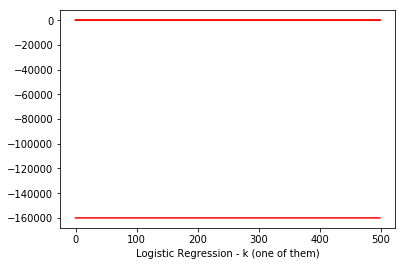

In [15]:
plt.plot(np.arange(0,len(output_logistic[:,0])),output_logistic[:,0], 'r-', alpha=1)
plt.xlabel('Logistic Regression - intercept')
plt.savefig('Data\\lr_intercept.png')

plt.plot(np.arange(0,len(output_logistic[:,1])),output_logistic[:,1], 'r-', alpha=1)
plt.xlabel('Logistic Regression - gender')
plt.savefig('Data\\lr_gender.png')

plt.plot(np.arange(0,len(output_logistic[:,10])),output_logistic[:,10], 'r-', alpha=1)
plt.xlabel('Logistic Regression - cancer type (one of them)')
plt.savefig('Data\\lr_cancertype.png')

plt.plot(np.arange(0,len(output_logistic[:,30])),output_logistic[:,30], 'r-', alpha=1)
plt.xlabel('Logistic Regression - k (one of them)')
plt.savefig('Data\\lr_k.png')

plt.plot(np.arange(0,len(output_factor_ln[:,2])),output_factor_ln[:,2], 'r-', alpha=1)
plt.xlabel('Factor Analysis - parameter')
plt.savefig('Data\\fa_1.png')

